# Titanic ML Model to Predict Survival

Below I will walk through my process of building a machine learning model to predict the survival of passengers aboard the Titanic. Please let me know if you have any suggestions on how to improve my model, or any questions about my work. Thanks for stopping by!

# 2. Feature Engineering  <a class="anchor"  id="chapter2"></a>

Our dataset already comes with many features, including Passenger Class, Sex, Age, Embarked Port, etc. In data analysis, it's important to be able to read between the lines in the data and extract other features that might help determine a passenger's survival. 

## 2.1 Extracting Title from Passenger Name<a class="anchor"  id="section_2_1"></a>

It looks like many of the passengers have associated titles in their names, such as "Miss.", "Mrs.", etc. Title could give us good insight into a passenger's age, marital status, gender, and social status, all of which could help predict a passenger's survival.
We can use regular expressions to extract passenger titles from their names.


In [2]:
# Importing regular expressions 
import re

# Extract names column from dataset
names = combined['Name']

# Regular expression that will extract a capital letter followed by lowercase letters and a period
title_pattern = re.compile(r'\b[A-Za-z]+\.')

# Extract titles from names
titles = []
for name in names:
    match = title_pattern.search(name)
    if match:
        titles.append(match.group())
        
# Add titles to new column in dataframe
combined['Title'] = titles

# Looking at the distribution of titles 
display(combined['Title'].value_counts())
display(combined['Title'].count())

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Mlle.          2
Major.         2
Ms.            2
Lady.          1
Sir.           1
Mme.           1
Don.           1
Capt.          1
Countess.      1
Jonkheer.      1
Dona.          1
Name: Title, dtype: int64

1309

It looks like every passenger has an associated title! Some are more common, such as "Mr." and "Miss.", while others such as "Major." and "Rev." have less than ten instances. Since our model is not going to learn anything interesting from a title with very few associated passengers, I will put these titles into a new group called 'Uncommon'. 

Before doing so, it appears that some of the uncommon titles can be recategorized into more common titles. 

Mlle. is a French title for an unmarried woman -> group into Miss.

Mme. is French title for a married woman -> group into Mrs.

Don. and Dona. can also be used as the Spanish forms of Mr. and Mrs., but often times they have more of an honorific meaning which could signify higher status. For this reason, I will not group these into Mr. and Mrs. 

There are also two passengers with the title "Ms." instead of "Miss.". According to [Scribbr](https://www.scribbr.com/effective-communication/ms-mrs-miss/#:~:text=Miss%20is%20the%20form%20always,are%20unsure%20how%20to%20address.), "*Miss is a title used for an unmarried woman... mainly for young women and girls (roughly up to the age of 30)*", while "*Ms. is generally used for unmarried women past the age of 30.*"

Upon doing some research on the title "Master.", I found the following: "*After its replacement in common speech by Mister, Master was retained as a form of address only for boys who had not yet entered society. By the late 19th century, etiquette dictated that men be addressed as Mister, and boys as Master.*" Because Master is being used here to refer to boys under the age of 18, let's plot the distribution for "Miss." and "Master." to make sure that it is not only for girls under the age of 18. 


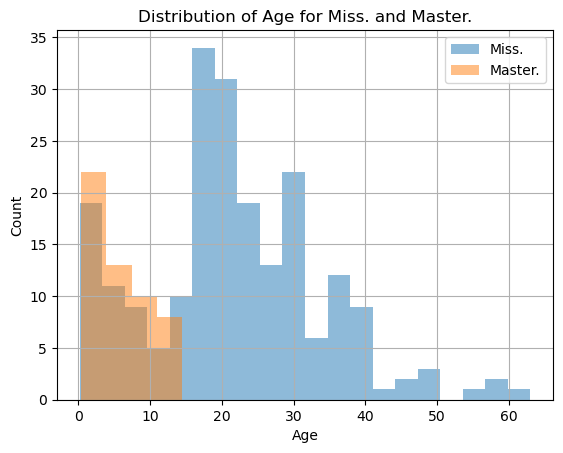

In [3]:
combined[combined['Title']=='Miss.']['Age'].dropna().hist(alpha=0.5, bins=20, label='Miss.')
combined[combined['Title']=='Master.']['Age'].dropna().hist(alpha=0.5, bins=4, label='Master.')

plt.title('Distribution of Age for Miss. and Master.')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

While the title "Master." is only for boys, the age distribution for "Miss." seems to span from girls at a very young age, all the way to women in their mid 60s. It seems that it was used as a way to signify both age (for girls) and marital status (for adult women). 

For this reason, it is appropriate to group "Ms." and "Mlle." into "Miss.". 

In [4]:
# Recategorize uncommon titles that fit into "Miss." and "Mrs."
combined.loc[combined['Title'].isin(['Ms.', 'Mlle.']), 'Title'] = 'Miss.'
combined.loc[combined['Title'].isin(['Mme.']), 'Title'] = 'Mrs.'

# Create new title 'Uncommon'
uncommon_titles = ['Major.', 'Lady.', 'Sir.', 'Don.', 'Capt.', 'Countess.', 'Jonkheer.', 'Dona.', 'Dr.', 'Rev.', 'Col.']
combined.loc[combined['Title'].isin(uncommon_titles), 'Title'] = 'Uncommon'

# Display count of each title 
display(combined['Title'].value_counts())

Mr.         757
Miss.       264
Mrs.        198
Master.      61
Uncommon     29
Name: Title, dtype: int64

## 2.2 Creating Women & Children Groupss <a class="anchor"  id="section_2_2"></a>

During my research for this kernel on The Titanic disaster, I found many sources stating that women & children were put on to rescue boats first, while men had to stand by. Apparently this was [a common code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first) in the 19th and 20th centuries in Britain during maritime disasters. Taking this theory one step further  leads to the assumption that if a family of women & children were indeed rescued, they would likely all be put on the same rescue boat together. Thus evolved the "Woman-Child-Group" theory, which states that groups of women & children from the same family either all live together or all die together, while adult men die almost without exception. I owe the credit for this theory to [Chris Deotte's kernel](https://www.kaggle.com/code/cdeotte/titanic-using-name-only-0-81818), which is just brilliant!

In accordance with this theory, I want to extract the following features from our dataset: 
* 'In_WCG': 1 if passenger is a woman or a child in a Woman-Child-Group, 0 otherwise 
* 'WCG_survived': 1 if the passenger is in a WCG, and of the people in the same WCG for whom we have 'Survived' data, the survival rate is greater than 50%; 0 otherwise 
* 'WCG_not_survived': 1 if the passenger is in a WCG, and of the people in the same WCG for whom we have 'Survived data, the survival rate is less than 50%; 0 otherwise

We can use last name in this dataset as a way to identify the passengers that were traveling together as a family. 

One thing to note is that the WCG feature extraction assumes that all passengers on *The Titanic* who shared the same last name were related, which I don't believe is necessarily true. There could be common last names that were shared between unrelated passengers. However, for the sake of our analysis, I will be using last name as a way to group families, and sort by gender and title to find Woman-Child-Groups.

In [5]:
def extract_last_name(name):
    # Split the name string on the comma character
    name_parts = name.split(',')
    # The last name is the first part of the resulting list
    last_name = name_parts[0]
    # Remove any leading or trailing whitespace
    last_name = last_name.strip()
    return last_name

# Apply the function to the 'Name' column of the DataFrame to create a new 'Last Name' column
combined['Last_name'] = combined['Name'].apply(extract_last_name)

# Creating column that only contains last names for groups with women & children
combined['Last_name_WCG'] = combined['Last_name']

# Filtering out adult males
combined.loc[((combined['Sex'] == 'male') & (combined['Title'] == 'Mr.'))|
             ((combined['Sex'] == 'male') & (combined['Title'] == 'Uncommon')), 'Last_name_WCG'] = np.nan

# Creating WCG_size variable that counts the number of passengers in a given women-child group
combined['WCG_size'] = combined.groupby('Last_name_WCG')['Last_name_WCG'].transform('count')
combined.loc[(combined['WCG_size'] < 2.0 ), 'Last_name_WCG'] = np.nan
combined.loc[(combined['WCG_size'] >= 2.0), 'In_WCG'] = 1
combined.loc[(combined['WCG_size'] < 2.0 ), 'In_WCG'] = 0

# Creating variables WCG_survived and WCG_not_survived to indicate known probability of survival in a given women-child group
for name in combined['Last_name_WCG'].unique():
    survival_rate = np.mean(combined[combined['Last_name_WCG']==name]['Survived'])
    if survival_rate > 0.5:
        combined.loc[combined['Last_name_WCG']==name, 'WCG_survived'] = 1
    else:
        combined.loc[combined['Last_name_WCG']==name, 'WCG_not_survived'] = 1
        
combined[['In_WCG', 'WCG_survived', 'WCG_not_survived']] = combined[['In_WCG', 'WCG_survived', 'WCG_not_survived']].fillna(0)

# Dropping 'Name', Last_name', 'Last_name_WCG', and 'WCG_size' as they are not relevant to my analysis
combined = combined.drop(columns=['Name', 'Last_name', 'Last_name_WCG', 'WCG_size'])

## 2.3 Party Size <a class="anchor"  id="section_2_3"></a>

There seem to be many people aboard *The Titanic* who were traveling with others. The total number of people that a passenger was traveling with might be a good predictor of their survival. A solo traveler might look out their own interests more than someone who ia traveling with siblings, parents, or even friends. 

We can infer a passenger's family size by using the variables 'SibSp' and 'Parch', but what about the passengers who were traveling with friends or others, such as a nanny or assistant? It appears that passengers who booked under the same reservation share the same ticket number. We can use a passenger's family size or the number of other passengers they share a ticket number with to determine how many people they were traveling with.

In [6]:
# Create variable 'Family_size' using 'SibSp' and 'Parch'
combined['Family_size'] = combined['SibSp'] + combined['Parch'] + 1

# Compare 'Party_size' to a value that counts the number of parties on a unique ticket 
# as some families seemed to have the same ticket number
display(combined['Ticket'].value_counts())

# Ticket only has 929 unique values, which means that 380 passengers were sharing a ticket
# with at least one other person, we can create a variable the counts this
combined['Ticket_group_size'] = combined.groupby('Ticket')['Ticket'].transform('count')

# Check in how many instances 'Family_size' and 'Ticket_group_size' are equal
display(combined[combined['Family_size']==combined['Ticket_group_size']])

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: Ticket, Length: 929, dtype: int64

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,In_WCG,WCG_not_survived,WCG_survived,Family_size,Ticket_group_size
1,2,1.0,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,0.0,0.0,0.0,2,2
2,3,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,0.0,0.0,0.0,1,1
3,4,1.0,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs.,0.0,0.0,0.0,2,2
4,5,0.0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr.,0.0,0.0,0.0,1,1
5,6,0.0,3,male,NaN,0,0,330877,8.4583,NaN,Q,Mr.,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,1304,NaN,3,female,28.0,0,0,347086,7.7750,NaN,S,Miss.,0.0,0.0,0.0,1,1
1304,1305,NaN,3,male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr.,0.0,0.0,0.0,1,1
1306,1307,NaN,3,male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr.,0.0,0.0,0.0,1,1
1307,1308,NaN,3,male,NaN,0,0,359309,8.0500,NaN,S,Mr.,0.0,0.0,0.0,1,1


It looks like family size and ticket group size match in 1025 instances out of 1309. That means the other 284 instances are mismatched somehow. Let's take a look at those instances to see what might be going on. 

In [7]:
mismatched = combined[combined['Family_size']!=combined['Ticket_group_size']]
display(len(mismatched[mismatched['Family_size']>mismatched['Ticket_group_size']]))
display(len(mismatched[mismatched['Family_size']<mismatched['Ticket_group_size']]))

84

200

Out of the 284 passengers where 'Family_size' and 'Ticket_group_size' are mismatched, there are 84 passengers where 'Family_size' is greater than 'Ticket_group_size', and 200 passengers where 'Ticket_group_size' is greater than 'Family_size'. 
* A family size that is greater than the ticket group size tells us that the passenger was traveling with family, but did not share a ticket ID with them. They could have booked separately at different ticket offices or boarded from different ports altogether. 
* A ticket group size that is greater than family size tells us that the passenger was likely traveling with someone that they were not related to, or did not fall under the definition of family according to the 'SibSp' and 'Parch' variables. A reminder that 'SibSp' (siblings and spouses) and 'Parch' (parents and children) are defined as follows:
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)
    * Parent = mother, father 
    * Child = daughter, son, stepdaughter, stepson (does not include nannies)

To create a finalized variable that shows the number of people a passenger was traveling with, I will take the larger of 'Family_size' and 'Ticket_group_size' for each passenger in the dataset. I will also create a binary variable 'Is_alone' to identify those who were traveling completely alone.

In [8]:
combined['Party_size'] = combined[['Family_size', 'Ticket_group_size']].max(axis=1)

combined['Is_alone'] = combined['Party_size'].apply(lambda x: 1 if x == 1 else 0)

# Drop 'Ticket' as it is not useful to my analysis
combined = combined.drop(columns='Ticket')

## 2.4 Fare Per Passenger <a class="anchor"  id="section_2_4"></a>

Let's take a look at the distribution of 'Fare' for each Pclass. 

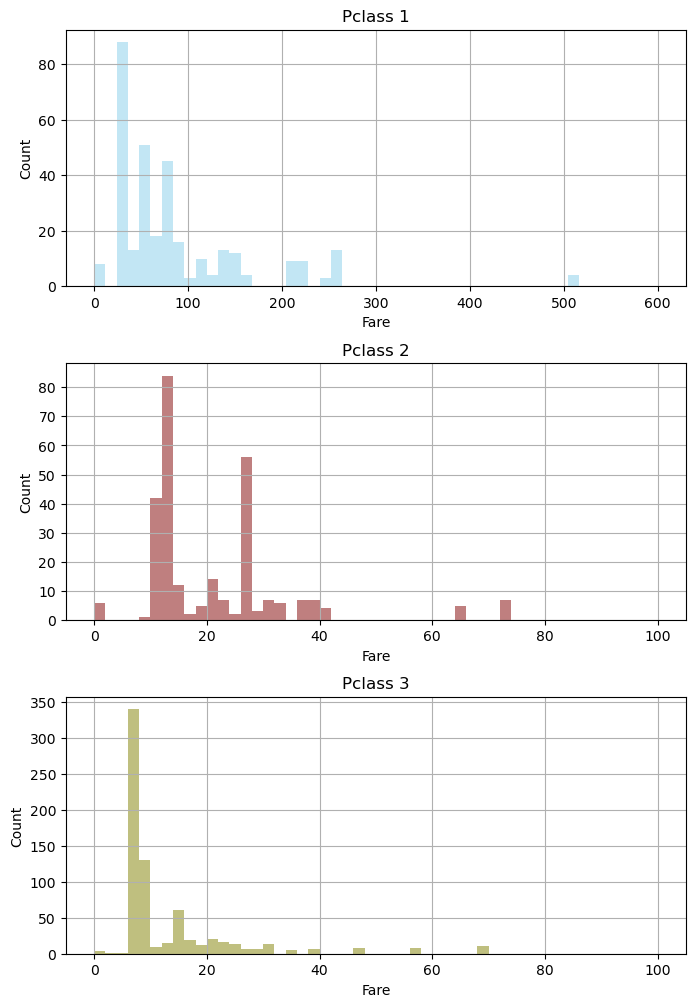

In [9]:
# Let's take a look at the distribution of 'Fare' for each Pclass

# Create a figure and axis object using subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    
# Pclass == 1
combined[combined['Pclass'] == 1]['Fare'].hist(alpha=0.5, ax=axs[0], bins=50, range=(0,600), color='skyblue')
axs[0].set_title('Pclass 1')
axs[0].set_xlabel('Fare')
axs[0].set_ylabel('Count')

# Pclass == 2
combined[combined['Pclass'] == 2]['Fare'].hist(alpha=0.5, ax=axs[1], bins=50, range=(0,100), color='maroon')
axs[1].set_title('Pclass 2')
axs[1].set_xlabel('Fare')
axs[1].set_ylabel('Count')

# Pclass == 2
combined[combined['Pclass'] == 3]['Fare'].hist(alpha=0.5, ax=axs[2], bins=50, range=(0,100), color='olive')
axs[2].set_title('Pclass 3')
axs[2].set_xlabel('Fare')
axs[2].set_ylabel('Count')
    
# Show the plot
plt.subplots_adjust(hspace=0.3)
plt.show()

There are quite a few outliers for each Pclass' fare distribution. Upon inspecting the data, all of the outliers are passengers who were traveling with multiple people under the same ticket reservation, i.e. they had a large 'Ticket_group_size'. It appears that the 'Fare' values are summed for passengers who had multiple people under the same ticket. In order to calculate fare per passenger, we can take 'Fare' and divide it by 'Ticket_group_size', which is already defined as the number of people sharing the same unique ticket number. Then, let's take a look at the distributions again and see if the outliers have resolved.

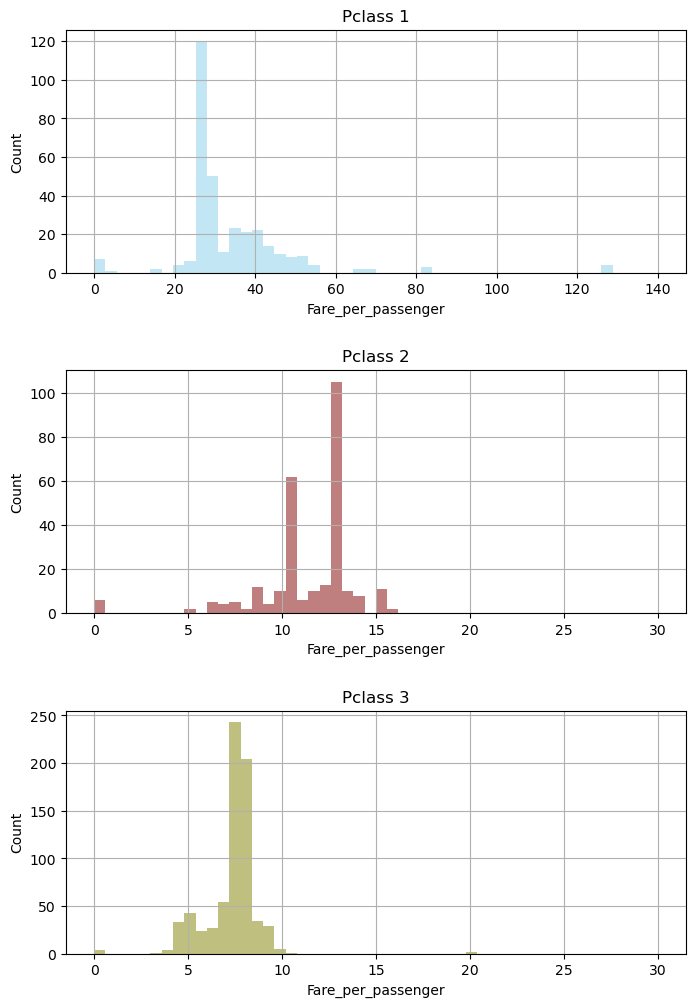

In [10]:
combined['Fare_per_passenger'] = combined['Fare'] / combined['Ticket_group_size']
         
# Create a figure and axis object using subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))

# Pclass == 1
combined[combined['Pclass'] == 1]['Fare_per_passenger'].hist(alpha=0.5, ax=axs[0], bins=50, range=(0,140), color='skyblue')
axs[0].set_title('Pclass 1')
axs[0].set_xlabel('Fare_per_passenger')
axs[0].set_ylabel('Count')

# Pclass == 2
combined[combined['Pclass'] == 2]['Fare_per_passenger'].hist(alpha=0.5, ax=axs[1], bins=50, range=(0,30), color='maroon')
axs[1].set_title('Pclass 2')
axs[1].set_xlabel('Fare_per_passenger')
axs[1].set_ylabel('Count')

# Pclass == 3
combined[combined['Pclass'] == 3]['Fare_per_passenger'].hist(alpha=0.5, ax=axs[2], bins=50, range=(0,30),  color='olive')
axs[2].set_title('Pclass 3')
axs[2].set_xlabel('Fare_per_passenger')
axs[2].set_ylabel('Count')

# Show the plot
plt.subplots_adjust(hspace=0.4)
plt.show()

Note that I have shrunk the x-axis ranges for the above graphs considerably, and the distributions are looking a lot less spread out. Looks like the creation of 'Fare_per_passenger' was able to resolve a lot of the outliers. We will use 'Fare_per_passenger' going forward in our analysis instead of 'Fare'.

In [11]:
combined = combined.drop(columns='Fare')

## 2.5 Creating Age Categories <a class="anchor"  id="section_2_5"></a>


If women and children were rescued first, I would assume that age is an important factor in survival, with children having higher survival rates than adults. There are over 250 missing values for 'Age' which I will impute later, but for now I will create 4 categories for 'Age' using KMeans Clustering. 

While I could keep 'Age' a continuous variable, I think it's more important that we are able to identify the youngest passengers and oldest passengers in discrete categories, as these passengers likely had higher survival rates. Let's take a look.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[13.44266554 27.83678908 43.53928809]


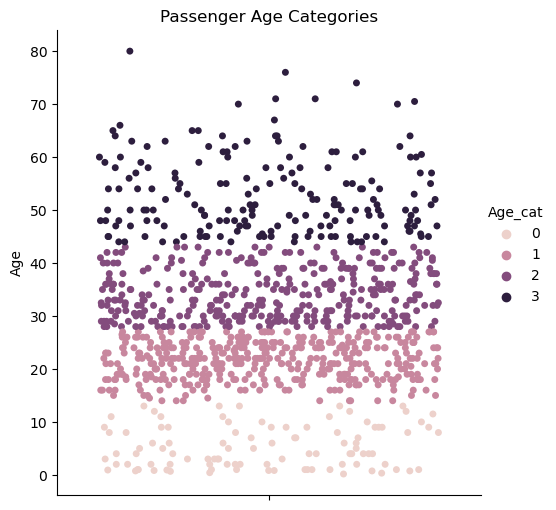

In [12]:
from sklearn.cluster import KMeans

# Splitting combined dataset based on missing 'Age' values
test_age = combined[combined['Age'].isna()]
train_age = combined[combined['Age'].notnull()]

# Fitting the KMeans clustering algorithm 
kmeans = KMeans(n_clusters=4, random_state=41)
labels = kmeans.fit_predict(train_age['Age'].to_numpy().reshape(-1,1))

# Define a mapping dictionary to relabel the clusters, 0 for youngest to 3 for oldest cluster
mapping = {label: i for i, label in enumerate(np.argsort(kmeans.cluster_centers_.flatten()))}
labels = [mapping[label] for label in labels]
train_age['Age_cat'] = labels

# Visualizing new age clusters
sns.catplot(y='Age', hue='Age_cat', data=train_age, jitter=0.4)
plt.title('Passenger Age Categories')

# Setting 'Age_cat' to missing for those with missing 'Age'
test_age['Age_cat'] = np.nan

# Combining back into full dataset
combined = pd.concat([train_age, test_age], axis=0)

# Finding age cutoffs for each cluster
centers = np.sort(kmeans.cluster_centers_.flatten())
cutoffs = (centers[:-1] + centers[1:]) / 2
print(cutoffs)

KMeans has created 4 clusters as follows: 
* 0 to 13.44 years
* 13.44 to 27.84 years
* 28.84 to 43.54 years
* 43.54 to 80 years

How do survival rates differ for these 4 clusters?

Age_cat
0    0.591549
1    0.372180
2    0.407115
3    0.370968
Name: 1.0, dtype: float64

Text(0, 0.5, 'Percent')

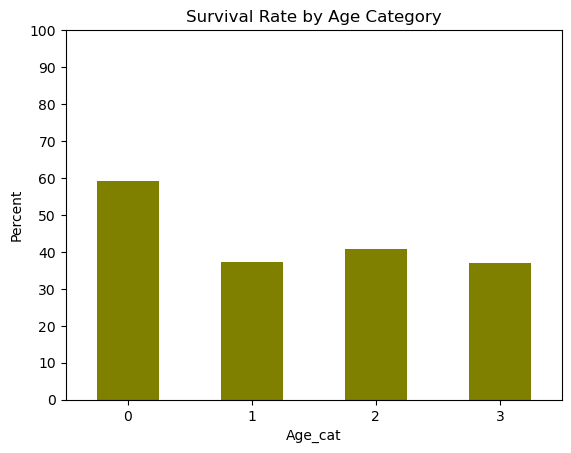

In [13]:
# Visualizing new age clusters
age_cat_survival = train_age.groupby(['Age_cat'])['Survived'].value_counts(normalize=True).unstack()
age_cat_survival = age_cat_survival[1]
display(age_cat_survival)
age_cat_survival.plot.bar(stacked=True, color=['olive'])
plt.title('Survival Rate by Age Category')
plt.xticks(rotation=360)
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
plt.ylabel('Percent')

Young children (under 13.44 years) had the best survival rate at 59.16%, while young adults (13.44 to 27.84 years) had the worst survival rate at 37.22%. This led me to wonder how these survival rates differ by gender. Let's take a look below.

Age_cat  Sex   
0        female    0.617647
         male      0.567568
1        female    0.747475
         male      0.149701
2        female    0.797753
         male      0.195122
3        female    0.794872
         male      0.176471
Name: 1.0, dtype: float64

Text(0, 0.5, 'Percent')

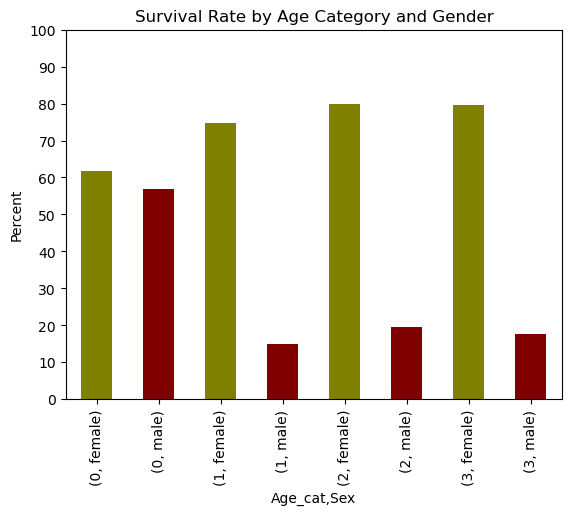

In [14]:
# Visualizing survival rates for each age cluster by gender
age_cat_survival = train_age.groupby(['Age_cat', 'Sex'])['Survived'].value_counts(normalize=True).unstack()
age_cat_survival = age_cat_survival[1]
display(age_cat_survival)
age_cat_survival.plot.bar(stacked=True, color=['olive', 'maroon'])
plt.title('Survival Rate by Age Category and Gender')
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
plt.ylabel('Percent')

It looks like males in the young adult age cluster were the least likely to get rescued. So if you were a male on *The Titanic*, what would get you rescued, other than being a boy under the age of 14? My first thought was money. Let's see if that is true...

Pclass
1    0.396040
2    0.151515
3    0.150198
Name: 1.0, dtype: float64

Text(0, 0.5, 'Percent')

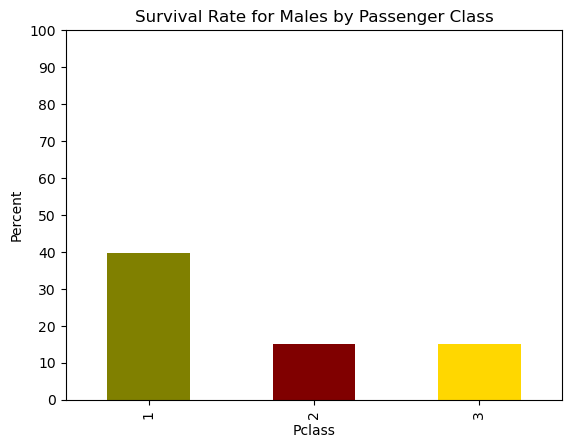

In [15]:
# Visualizing survival rates for each age cluster by class
males = train_age[train_age['Sex']=='male']
age_cat_survival = males.groupby(['Pclass'])['Survived'].value_counts(normalize=True).unstack()
age_cat_survival = age_cat_survival[1]
display(age_cat_survival)
age_cat_survival.plot.bar(stacked=True, color=['olive', 'maroon', 'gold'])
plt.title('Survival Rate for Males by Passenger Class')
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
plt.ylabel('Percent')

Looks like male passengers in first class were more likely to get rescued than passengers in second and third class, although the majority of male passengers across the board met the same tragic fate.